In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
def load_and_explore_data():
    # Загружаем основные данные
    dd_transactions = dd.read_parquet('transaction_fraud_data.parquet', engine='pyarrow')
    df_transactions = dd_transactions.compute()
    dd_currency = dd.read_parquet('historical_currency_exchange.parquet', engine='pyarrow')
    df_currency = dd_currency.compute()
    
    print("✅ Данные успешно загружены!")
    print(f"Транзакции: {df_transactions.shape}")
    print(f"Курсы валют: {df_currency.shape}")
    
    return df_transactions, df_currency
    
df, currency_df = load_and_explore_data()
# Преобразование timestamp к datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["hour"] = df["timestamp"].dt.hour

✅ Данные успешно загружены!
Транзакции: (7483766, 23)
Курсы валют: (31, 12)


### Гипотеза 1: "Ночные мошенники" (0-6 часов)

Гипотеза 1:
Ночь (0-6ч): 46.88% мошенничества
День: 12.17%



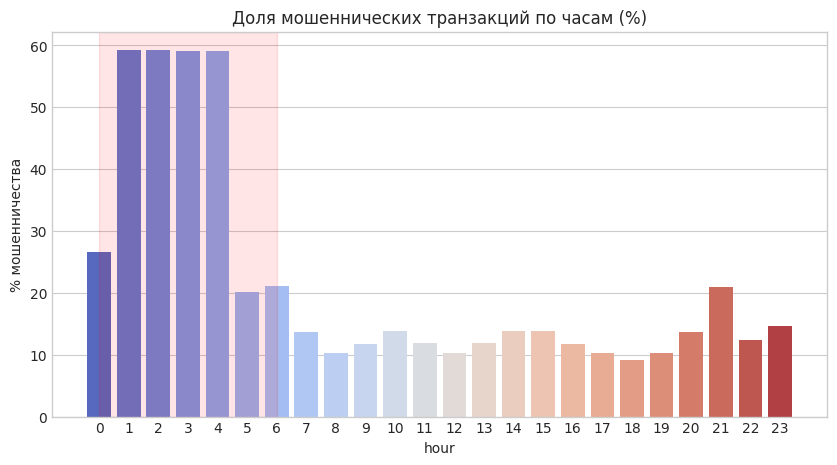

In [4]:
def hypo1(df):
    night_mask = df["hour"].between(0, 6)
    day_mask = ~night_mask

    night_fraud_rate = df.loc[night_mask, "is_fraud"].mean() * 100
    day_fraud_rate = df.loc[day_mask, "is_fraud"].mean() * 100

    print(f"Гипотеза 1:\nНочь (0-6ч): {night_fraud_rate:.2f}% мошенничества\nДень: {day_fraud_rate:.2f}%\n")

    hourly = df.groupby("hour")["is_fraud"].mean() * 100
    plt.figure(figsize=(10,5))
    sns.barplot(x=hourly.index, y=hourly.values, palette="coolwarm")
    plt.axvspan(0, 6, color='red', alpha=0.1)
    plt.title("Доля мошеннических транзакций по часам (%)")
    plt.ylabel("% мошенничества")
    plt.show()

hypo1(df)

In [ ]:
def is_night(h):
# Ночь: 0-5 включительно (0,1,2,3,4,5); как в сводке 0-6 часов — обычно считают 0-5
# Если вы хотите включить 6:00, поменяйте условие на h <= 6
    return (h >= 0) & (h <= 5)

df["is_night"] = df["hour"].apply(is_night)

In [ ]:
night = df[df["is_night"] == True]
succ_night = int(night["is_fraud"].sum()) # число "успехов" (мошенничество)
n_night = int(night.shape) # общее число наблюдений

day = df[df["is_night"] == False]
succ_day = int(day["is_fraud"].sum())
n_day = int(day.shape)

p_night = succ_night / n_night
p_day = succ_day / n_day

print("Общие метрики:")
print(f"- Ночь: мошенничеств = {succ_night} из {n_night} (p_night = {p_night:.3f})")
print(f"- День: мошенничеств = {succ_day} из {n_day} (p_day = {p_day:.3f})")
print(f"- Разность долей (night - day) = {p_night - p_day:.3f}")